In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 1. Read the data

In [4]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import Dataset, DataLoader

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(f'The shape of training data is {train_data.shape}\nThe shape of testing data is {test_data.shape}')

The shape of training data is (1460, 81)
The shape of testing data is (1459, 80)


In [8]:
# visualize some of the data and their features
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 2. Data Preprocessing

In [10]:
# replace all the numeric nan value with feature mean and do standardization
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean())/ (x.std()))

all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [11]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [12]:
# get dummies increase the number of features to 331
all_features.columns.unique()

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=331)

## 3. Training

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[: n_train].values, dtype = torch.float32, device=device)
test_features = torch.tensor(all_features[n_train: ].values, dtype = torch.float32, device=device)
train_labels = torch.tensor(
    train_data['SalePrice'].values.reshape(-1, 1), dtype = torch.float32, device=device
)

In [15]:
# get the data
batch_size = 64
class Train(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label
    
    def __len__(self):
        return len(self.features)

In [16]:
loss = nn.MSELoss()
# Define the loss function
def log_rmse(preds, y):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(y)))
    return rmse

In [17]:
def train(num_epochs, net, train_features, train_labels, test_features, test_labels, batch_size, loss, optimizer, silent = True):
    train_ls, test_ls = [], []
    # get the training data iterator
    train_iter = DataLoader(Train(train_features, train_labels), batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            l = loss(net(X), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net(train_features), train_labels).item())
        if test_labels is not None:
            test_ls.append(log_rmse(net(test_features), test_labels).item())

        if not silent:
            if (epoch + 1) % 100 == 0:
                print(f'After {epoch + 1} epochs, the log rmse is {train_ls[-1]}')
    
    return train_ls, test_ls

In [18]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, num_epochs, X_train, y_train, batch_size, loss, lr, wd, initialize = (None, None)):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        net = get_net(*initialize).to(device)
        optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=wd)
        data = get_k_fold_data(k, i, X_train, y_train) 
        train_ls, valid_ls = train(num_epochs, net, *data, batch_size, loss, optimizer)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        print(f'Fold {i + 1}, training log rmse {float(train_ls[-1]):f}, '
              f'validating log rmse {float(valid_ls[-1]):f}')

    d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
            xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
            legend=['train', 'valid'], yscale='log')
    
    return train_l_sum / k, valid_l_sum / k

In [44]:
# Define the number of folds
k = 5
# Define the number of epochs to train
num_epochs = 1000
# Define the batch size
batch_size = 256

In [45]:
# Define a simple linear model
in_features = train_features.shape[1]
# in every k-fold we need a new model so we cannot use net as a parameter of the function

def get_net(mean = None, std = None):
    net = nn.Sequential(nn.Linear(in_features, 1))
    if mean != None and std != None:
        torch.nn.init.normal_(net[0].weight, mean, std)
    return net

In [46]:
# pre-train a model to help initialization
net_test = get_net().to(device)
optimizer = torch.optim.Adam(params=net_test.parameters(), lr=5, weight_decay=0)
_, _ = train(300, net_test, train_features, train_labels, None, None, 128, loss, optimizer)
w_mean = net_test[0].weight.mean()
w_std = net_test[0].weight.std()
print(f'Mean of weights is {w_mean}\nStd of weights is {w_std}')

Mean of weights is 2971.9619140625
Std of weights is 2530.337646484375


In [22]:
# Define the optimizer
wd = 0
lr = 5

Fold 1, training log rmse 0.117248, validating log rmse 0.141369
Fold 2, training log rmse 0.108147, validating log rmse 0.143599
Fold 3, training log rmse 0.109226, validating log rmse 0.140532
Fold 4, training log rmse 0.142788, validating log rmse 0.137448
Fold 5, training log rmse 0.103898, validating log rmse 0.153459


(0.11626139283180237, 0.14328136742115022)

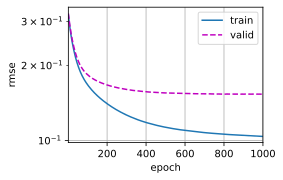

In [26]:
k_fold(k, num_epochs, train_features, train_labels, batch_size, log_rmse, lr, wd, initialize=(w_mean.item(), w_std.item()))

## 4. More complex neural networks

In [49]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2):
        super().__init__()
        self.num_inputs = num_inputs
        self.lin_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, num_hidden1),
            nn.ReLU(),
            nn.Linear(num_hidden1, num_hidden2),
            nn.ReLU(),
            nn.Linear(num_hidden2, num_outputs),
        )
        self.num_layers = len(self.lin_relu_stack)
    
    def forward(self, X):
        out = self.lin_relu_stack(X)

        return out

    def __getitem__(self, idx):
        return self.lin_relu_stack[idx]

num_inputs, num_outputs, num_hidden1, num_hidden2 = train_features.shape[1], 1, 256, 256

def get_net(mean = None, std = None):  
    net = NeuralNetwork(num_inputs, num_outputs, num_hidden1, num_hidden2)

    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
    
    if mean == None and std == None:
        net.apply(init_weights)
    return net

Fold 1, training log rmse 0.104754, validating log rmse 0.130542
Fold 2, training log rmse 0.102823, validating log rmse 0.141181
Fold 3, training log rmse 0.105781, validating log rmse 0.133612
Fold 4, training log rmse 0.096859, validating log rmse 0.106482
Fold 5, training log rmse 0.102161, validating log rmse 0.149808


(0.1024754986166954, 0.13232491165399551)

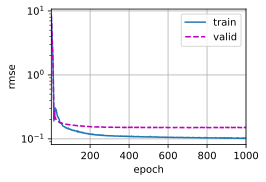

In [50]:
lr = 0.005
wd = 1e5
k_fold(k, 1000, train_features, train_labels, batch_size, loss, lr, wd)

In [51]:
net_test = get_net().to(device)
optimizer = torch.optim.Adam(net_test.parameters(), lr = lr, weight_decay = wd)
_, _ = train(1000, net_test, train_features, train_labels, None, None, batch_size, loss, optimizer, False)

After 100 epochs, the log rmse is 0.14650821685791016
After 200 epochs, the log rmse is 0.12841519713401794
After 300 epochs, the log rmse is 0.12010485678911209
After 400 epochs, the log rmse is 0.11678499728441238
After 500 epochs, the log rmse is 0.11404123157262802
After 600 epochs, the log rmse is 0.112068310379982
After 700 epochs, the log rmse is 0.11266129463911057
After 800 epochs, the log rmse is 0.1119161993265152
After 900 epochs, the log rmse is 0.10756271332502365
After 1000 epochs, the log rmse is 0.1071329414844513


In [63]:
net_test[0].weight

Parameter containing:
tensor([[-3.9395e-02,  6.7454e-02,  1.8331e-01,  ...,  2.3852e-01,
          1.1985e-01,  0.0000e+00],
        [-4.2322e-02,  6.8449e-02,  1.9466e-01,  ...,  2.5561e-01,
          1.2900e-01,  0.0000e+00],
        [-3.2598e-02,  5.7188e-02,  1.5526e-01,  ...,  1.9828e-01,
          9.8590e-02,  8.6969e-05],
        ...,
        [-3.8073e-02,  6.4434e-02,  1.7812e-01,  ...,  2.3073e-01,
          1.1571e-01, -2.0209e-06],
        [-1.5997e+00, -1.0925e+00,  1.1555e-01,  ..., -1.0871e-01,
          1.9124e-01,  2.8026e-45],
        [-3.3305e-02,  5.9130e-02,  1.5824e-01,  ...,  2.0250e-01,
          1.0080e-01,  0.0000e+00]], device='cuda:0', requires_grad=True)

In [70]:
net = NeuralNetwork(num_inputs, num_outputs, num_hidden1, num_hidden2).to(device)
for i in range(net.num_layers):
    m = net[i]
    if type(m) == nn.Linear:
        m.weight = net_test[i].weight
        m.bias = net_test[i].bias

In [71]:
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = 1e-5)
train(1000, net, train_features, train_labels, None, None, batch_size, log_rmse, optimizer, False)

After 100 epochs, the log rmse is 0.12256121635437012
After 200 epochs, the log rmse is 0.11724026501178741
After 300 epochs, the log rmse is 0.11452291905879974
After 400 epochs, the log rmse is 0.11231954395771027
After 500 epochs, the log rmse is 0.11056375503540039
After 600 epochs, the log rmse is 0.10878732800483704
After 700 epochs, the log rmse is 0.10719335824251175
After 800 epochs, the log rmse is 0.10415732115507126
After 900 epochs, the log rmse is 0.10043918341398239
After 1000 epochs, the log rmse is 0.09773299843072891


([7.370893955230713,
  5.6835713386535645,
  4.692821025848389,
  4.0114617347717285,
  3.498504400253296,
  3.0895628929138184,
  2.750168561935425,
  2.459429979324341,
  2.2046241760253906,
  1.9776860475540161,
  1.7735025882720947,
  1.5878573656082153,
  1.4176979064941406,
  1.2607606649398804,
  1.1155773401260376,
  0.9813475012779236,
  0.8574352860450745,
  0.7430417537689209,
  0.6380534172058105,
  0.5423856973648071,
  0.4566783607006073,
  0.38175153732299805,
  0.318684458732605,
  0.26905834674835205,
  0.23271968960762024,
  0.20785315334796906,
  0.19117790460586548,
  0.17973002791404724,
  0.17222720384597778,
  0.16802799701690674,
  0.16514113545417786,
  0.16229592263698578,
  0.159581258893013,
  0.1572405844926834,
  0.155166894197464,
  0.15330001711845398,
  0.15151773393154144,
  0.1499338150024414,
  0.14844976365566254,
  0.1470787227153778,
  0.14576677978038788,
  0.14452962577342987,
  0.1433134377002716,
  0.14235500991344452,
  0.14131613075733185,
 

## Train and predict

In [ ]:
num_epochs = 300
net = NeuralNetwork(num_inputs, num_outputs, num_hidden1, num_hidden2).to(device)
batch_size = 256

lr = 0.01
wd = 2
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = wd)

In [ ]:
train_loss, _ = train(num_epochs, net, train_features, train_labels, None, None, batch_size, loss, optimizer, False)

In [67]:
def pred(net, test_features, test_data):
    result = net(test_features).detach()
    if device != 'cpu':
        result = result.cpu()
    test_data['SalePrice'] = result.numpy()
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

pred(net, test_features, test_data)

In [ ]:
d2l.plot(np.arange(1, num_epochs + 1), [train_loss], xlabel='epoch',
            ylabel='log rmse', xlim=[1, num_epochs], yscale='log')